In [1]:
from dataclasses import dataclass
from typing import Dict, Iterable

import numpy as np
import numpy.typing as npt
import pandas as pd
from matplotlib import pyplot as plt
from scipy import signal


In [2]:
def convert_complex_numbers(frame: pd.DataFrame) -> pd.DataFrame:
    """
    Convert complex numbers strings where 'i' (Math convention) is used to use 'j' (Engineering convention) instead
    and convert it to numpy complex number type.
    :param frame: A Pandas dataframe
    :return: A data frame containing numpy complex numbers.
    """
    return frame.map(lambda row: np.csingle(row.replace("i", "j")))[0]


# Read the data where b = Bluetooth, w = WiFi, z = Zigbee. So the frame
# called 'zb' means it is the spectrogram containing Zigbee and Bluetooth
# signals.
data_frames: Dict[str, pd.DataFrame] = {
    "b": pd.read_csv("data/csv/B_SNR30.csv", sep=",", header=None, dtype=str),
    "bw": pd.read_csv("data/csv/BW_SNR30.csv", sep=",", header=None, dtype=str),
    "w": pd.read_csv("data/csv/W_SNR30.csv", sep=",", header=None, dtype=str),
    "z": pd.read_csv("data/csv/Z_SNR30.csv", sep=",", header=None, dtype=str),
    "zb": pd.read_csv("data/csv/ZB_SNR30.csv", sep=",", header=None, dtype=str),
    "zw": pd.read_csv("data/csv/ZW_SNR30.csv", sep=",", header=None, dtype=str),
    "zbw": pd.read_csv("data/csv/ZBW_SNR30.csv", sep=",", header=None, dtype=str)
}

# Convert complex number notation
data_frames = {key: convert_complex_numbers(frame) for key, frame in data_frames.items()}

In [6]:
@dataclass
class Spectrogram:
    """
    This stores the information required to interpret a spectrogram.
    
    f are the frequencies
    t are an array of time intervals
    values is a 2D numpy array for the magnitudes for each frequency f at time t.
    """
    f: [int]
    t: [int]
    values: npt.NDArray[float]


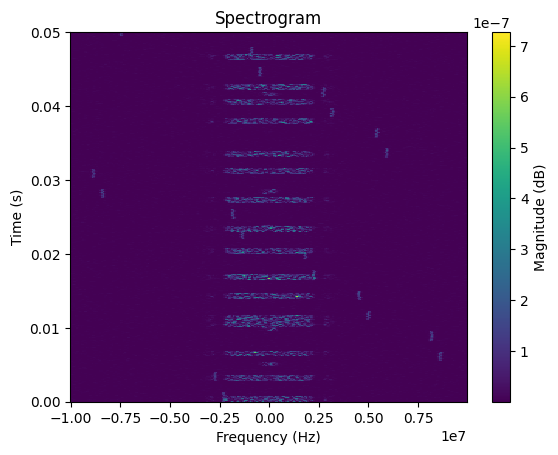

In [8]:
# Sampling frequency
fs = 20000000  # Hz


def move_front_half_to_end(array: npt.NDArray) -> npt.NDArray:
    """
    Move the front half of an array to the end
    """
    n = len(array)
    return np.concatenate((array[n // 2:], array[:n // 2]))


def create_spectrogram(x: Iterable) -> Spectrogram:
    """
    Create a spectrogram of a signal.
    :param x: The signal
    :return: A Spectrogram instance that contains the frequencies, time and values.
    """

    # Calculate Short Time Fourier Transform of the signal.
    # return_one_sided is needed because the data is complex
    f, t, Zxx = signal.stft(x=x, fs=fs, return_onesided=False)

    # A spectrogram is the absolute value of the STFT and then squared.
    Zxx_abs = (np.abs(Zxx) ** 2)

    # For some reason our spectrogram has the negative frequencies in
    # the *last* half of the data so this method moves to the front
    # This can help with plotting because to use 'nearest' shading requires the 
    # data to be monotonically increasing/decreasing in value. 
    return Spectrogram(move_front_half_to_end(f), t, move_front_half_to_end(Zxx_abs))


spec = create_spectrogram(data_frames["zbw"])
